<a href="https://colab.research.google.com/github/amannarsaria4/fast.ai/blob/master/Lesson%203/(MyCode)lesson3_camvid_tiramisuipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Image Segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [ ]:
!git clone https://github.com/alexgkendall/SegNet-Tutorial.git

fatal: destination path 'SegNet-Tutorial' already exists and is not an empty directory.


###Data

In [ ]:
path = Path('./SegNet-Tutorial/CamVid')

In [ ]:
path.ls()

[PosixPath('SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('SegNet-Tutorial/CamVid/models'),
 PosixPath('SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('SegNet-Tutorial/CamVid/valannot'),
 PosixPath('SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('SegNet-Tutorial/CamVid/test'),
 PosixPath('SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('SegNet-Tutorial/CamVid/testannot'),
 PosixPath('SegNet-Tutorial/CamVid/train'),
 PosixPath('SegNet-Tutorial/CamVid/val')]

In [ ]:
f_names = get_image_files(path/'val')
f_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08029.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08027.png'),
 PosixPath('SegNet-Tutorial/CamVid/val/0016E5_08103.png')]

In [ ]:
lab_names = get_image_files(path/'valannot')
lab_names[:3]

[PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08029.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08027.png'),
 PosixPath('SegNet-Tutorial/CamVid/valannot/0016E5_08103.png')]

In [ ]:
def get_y_fn(x): 
  return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

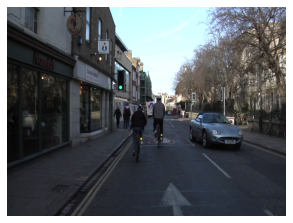

In [ ]:
img_f = f_names[0]
img = open_image(img_f)
img.show(figsize = (5,5))

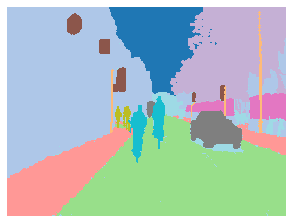

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize = (5,5),alpha = 1)

In [ ]:
src_size = np.array(mask.shape[1:])

In [ ]:
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

In [ ]:
mask.shape

torch.Size([1, 360, 480])

In [ ]:
bs = 4

###Datasets

In [ ]:
src = SegmentationItemList.from_folder(path).split_by_folder(valid = 'val').label_from_func(get_y_fn, classes = codes)


In [ ]:
data = src.transform(get_transforms(), tfm_y = True, size = src_size//2).databunch().normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


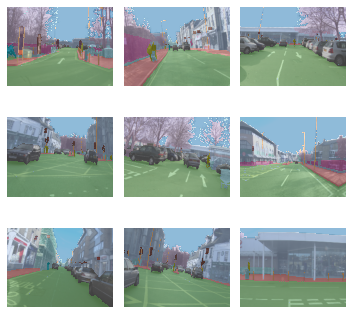

In [ ]:
data.show_batch(3, figsize=(5,5))

###Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
wd = 1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics = metrics,wd = wd, bottle = True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


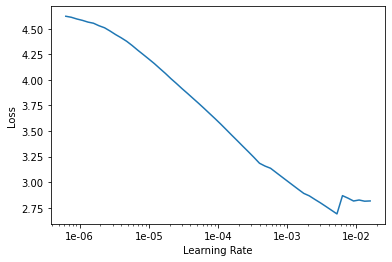

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 2e-3

In [ ]:
learn.fit_one_cycle(10, max_lr = slice(lr), pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.177398,2.190281,0.266004,00:15
1,2.580453,1.872994,0.448864,00:12
2,2.251347,1.806965,0.533181,00:12
3,2.003784,1.442325,0.584367,00:12
4,1.803362,1.417826,0.533340,00:12
5,1.652337,1.171950,0.731410,00:12
6,1.550227,1.275552,0.671487,00:12
7,1.452758,0.949730,0.767779,00:12
8,1.344850,0.747189,0.792971,00:12
9,1.245847,0.744638,0.799112,00:12


In [ ]:
learn.save('stage-1')
learn.load('stage-1')


Learner(data=ImageDataBunch;

Train: LabelList (367 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: SegNet-Tutorial/CamVid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240),Image (3, 180, 240)
y: SegmentationLabelList
ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240),ImageSegment (1, 180, 240)
Path: SegNet-Tutorial/CamVid;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [ ]:
learn.load('stage-2')

NameError: ignored

In [ ]:
learn.unfreeze()

NameError: ignored

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12,max_lr = lrs, pct_start = 0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.665597,0.706328,0.804326,00:13


RuntimeError: ignored

In [ ]:
learn.save('stage-2')

###Bigger Model

In [ ]:
data = src.transform(get_transforms(), tfm_y = True, size = src_size).databunch().normalize(imagenet_stats)

In [ ]:
data.show(3, figsize = (5,5))


In [ ]:
learn = unet_learner(data, models.resnet34, bottle = True, wd = wd, metrics = metrics)

In [ ]:
learn.load('stage-2')


In [ ]:
learn.fit_one_cycle(12, max_lr = slice(1e-3), pct_start = 0.8)

In [ ]:
learn.save('stage-1-big')
learn.load('stage-1-big')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(12,max_lr = slice(1e-6,1e-4), pct_start = 0.8)

In [ ]:
learn('stage-2-big')
learn('stage-2-big')

In [ ]:
learn.show_results(3, figsize = (9,11))

In [ ]:
learn.destroy()

this object has been destroyed


In [ ]:
from fastai.utils.mem import *
free = gpu_mem_get_free_no_cache()
free

795